<a href="https://colab.research.google.com/github/sidt-ai/data-science-competitions/blob/main/analytics_vidhya/jobathon_jun22/notebooks/01_eda_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%%capture
!pip install xgboost==1.6.1

In [ ]:
import os
import gc
import warnings

gc.enable()
warnings.filterwarnings('ignore')

%pprint

In [53]:
import numpy as np
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

from xgboost import XGBClassifier

In [ ]:
SEED = 2311

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [3]:
train_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/analytics_vidhya/jobathon_jun22/data/raw/train.csv'
test_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/analytics_vidhya/jobathon_jun22/data/raw/test.csv'
sub_url = 'https://raw.githubusercontent.com/sidt-ai/data-science-competitions/main/analytics_vidhya/jobathon_jun22/data/raw/sample_submission.csv'

In [4]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# EDA

## Overview

In [5]:
train.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    13184 non-null  int64  
 1   created_at            13184 non-null  object 
 2   campaign_var_1        13184 non-null  int64  
 3   campaign_var_2        13184 non-null  int64  
 4   products_purchased    5048 non-null   float64
 5   signup_date           6535 non-null   object 
 6   user_activity_var_1   13184 non-null  int64  
 7   user_activity_var_2   13184 non-null  int64  
 8   user_activity_var_3   13184 non-null  int64  
 9   user_activity_var_4   13184 non-null  int64  
 10  user_activity_var_5   13184 non-null  int64  
 11  user_activity_var_6   13184 non-null  int64  
 12  user_activity_var_7   13184 non-null  int64  
 13  user_activity_var_8   13184 non-null  int64  
 14  user_activity_var_9   13184 non-null  int64  
 15  user_activity_var_1

## Dependent variable

In [8]:
train.buy.nunique(), train.buy.unique()

(2, array([0, 1]))

Binary categorical target.

In [9]:
train.buy.value_counts(normalize=True)

0    0.949
1    0.051
Name: buy, dtype: float64

Heavily imbalanced. Will require resampling techniques or anomaly detection approach.

## Independent variables

### id

In [10]:
len(set(train.id.unique()) - set(test.id.unique())), len(set(test.id.unique()) - set(train.id.unique()))

(39161, 13184)

No common $id$s.

In [11]:
train.id.nunique(), test.id.nunique()

(39161, 13184)

All unique. Will be dropping $id$ from the features.

### created_at, signup_date

In [12]:
train['created_at'] = pd.to_datetime(train['created_at'])
test['created_at'] = pd.to_datetime(test['created_at'])

In [13]:
train['created_at'].isna().any().any(), test['created_at'].isna().any().any()

(False, False)

In [14]:
train['signup_date'] = pd.to_datetime(train['signup_date'])
test['signup_date'] = pd.to_datetime(test['signup_date'])

In [15]:
train['signup_date'].isna().any().any(), test['signup_date'].isna().any().any()

(True, True)

In [16]:
train['signup_date'].isna().sum().sum(), test['signup_date'].isna().sum().sum()

(15113, 6649)

In [17]:
train['signup_date'].fillna(train['created_at'], inplace=True)
test['signup_date'].fillna(test['created_at'], inplace=True)

In [18]:
train['date_gap_months'] = (train['created_at'] - train['signup_date']) / np.timedelta64(1, 'M')
test['date_gap_months'] = (test['created_at'] - test['signup_date']) / np.timedelta64(1, 'M')

In [19]:
train[['created_at', 'signup_date', 'date_gap_months']].head()

,created_at,signup_date,date_gap_months
0,2021-01-01,2020-09-24,3.2526
1,2021-01-01,2020-09-19,3.4169
2,2021-01-01,2021-08-11,-7.2938
3,2021-01-01,2017-10-04,38.9330
4,2021-01-01,2020-06-08,6.8010


In [20]:
def create_date_features(df):
    df['created_at_quarter'] = df['created_at'].dt.quarter
    df['created_at_month'] = df['created_at'].dt.month
    df['created_at_day'] = df['created_at'].dt.day
    df['created_at_dayofweek'] = df['created_at'].dt.day_of_week

    return df

In [21]:
train = create_date_features(train)
test = create_date_features(test)

### campaign_var_*

In [22]:
sorted(train['campaign_var_1'].unique()), sorted(test['campaign_var_1'].unique())

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

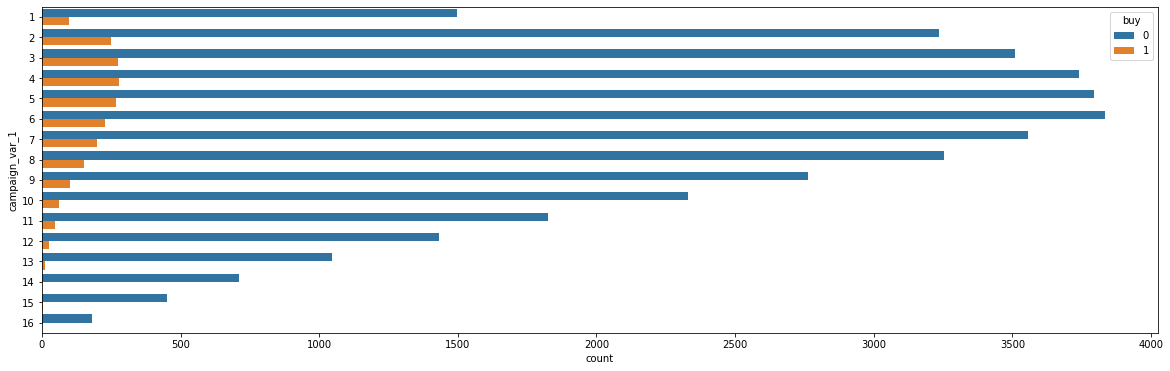

In [23]:
plt.figure(figsize=(20, 6))
sns.countplot(y='campaign_var_1', data=train, hue='buy')
plt.show()

In [24]:
sorted(train['campaign_var_2'].unique()), sorted(test['campaign_var_2'].unique())

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

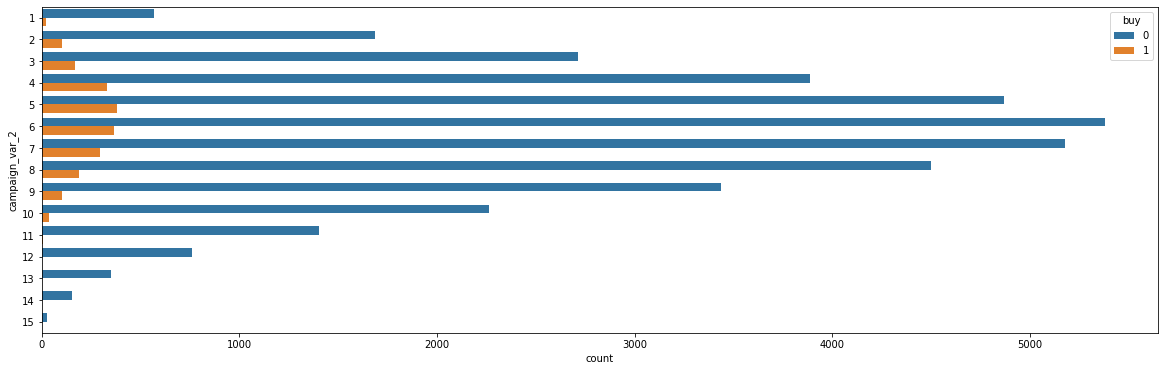

In [25]:
plt.figure(figsize=(20, 6))
sns.countplot(y='campaign_var_2', data=train, hue='buy')
plt.show()

### products_purchased

In [26]:
print(f'Train missing: {train.products_purchased.isna().sum().sum() / len(train) * 100:.2f} %')
print(f'Test missing: {test.products_purchased.isna().sum().sum() / len(test) * 100:.2f} %')

Train missing: 53.40 %
Test missing: 61.71 %


In [27]:
train['products_purchased'].min(), train['products_purchased'].max()

(1.0, 4.0)

In [28]:
test['products_purchased'].min(), test['products_purchased'].max()

(1.0, 4.0)

In [29]:
train['products_purchased'].value_counts(normalize=True)

2.0    0.4859
3.0    0.2753
1.0    0.1996
4.0    0.0392
Name: products_purchased, dtype: float64

We can fill the missing values with $0$ for number of products purchased.

In [30]:
train['products_purchased'].fillna(0, inplace=True)
test['products_purchased'].fillna(0, inplace=True)

In [31]:
train['products_purchased'] = train['products_purchased'].astype('int')
test['products_purchased'] = test['products_purchased'].astype('int')

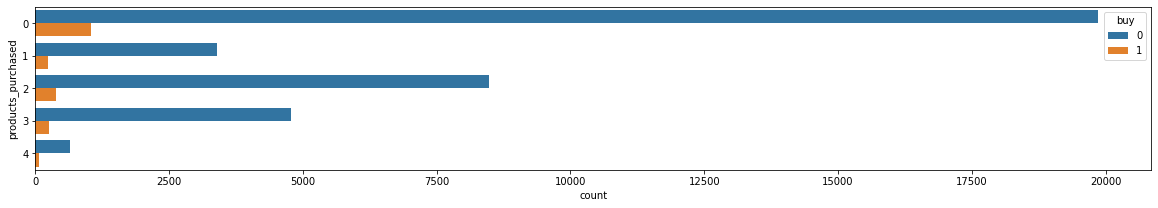

In [32]:
plt.figure(figsize=(20, 3))
sns.countplot(y='products_purchased', data=train, hue='buy')
plt.show()

### user_activity_var_*

In [33]:
user_vars = ['user_activity_var_' + str(i) for i in range(1, 13)]

In [34]:
train[user_vars].nunique()

user_activity_var_1     4
user_activity_var_2     2
user_activity_var_3     2
user_activity_var_4     2
user_activity_var_5     3
user_activity_var_6     4
user_activity_var_7     3
user_activity_var_8     3
user_activity_var_9     2
user_activity_var_10    2
user_activity_var_11    5
user_activity_var_12    2
dtype: int64

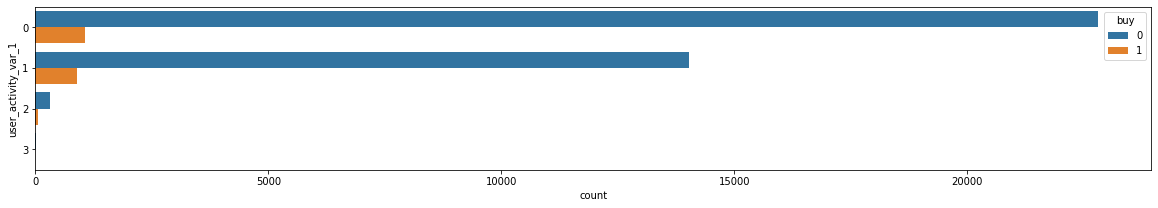

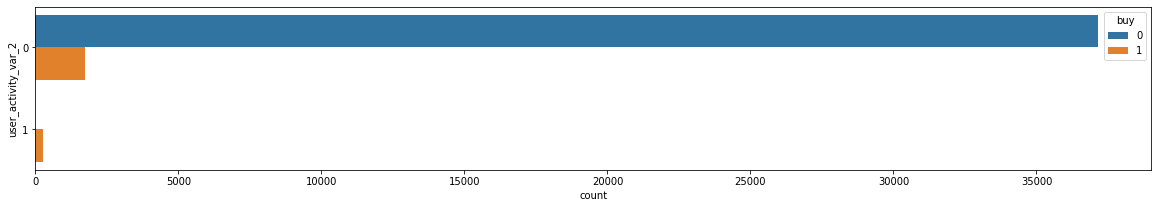

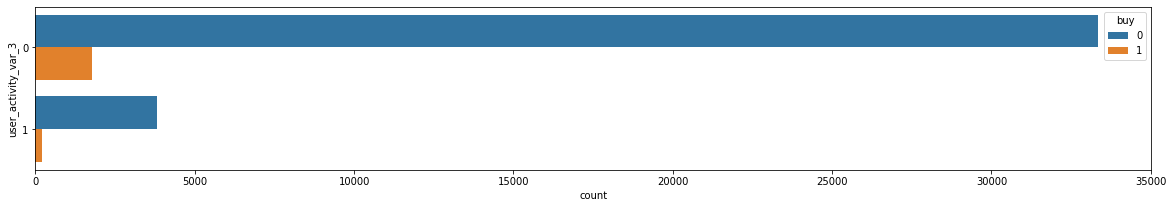

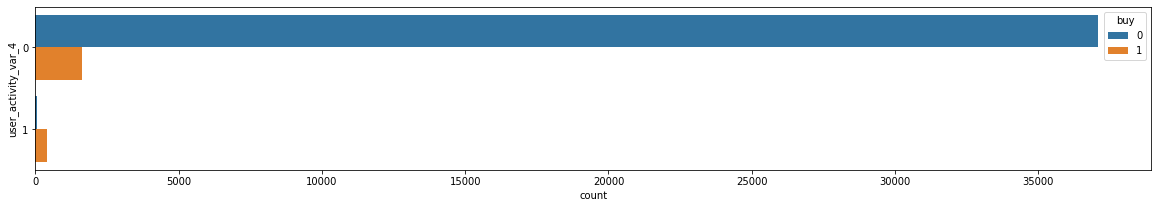

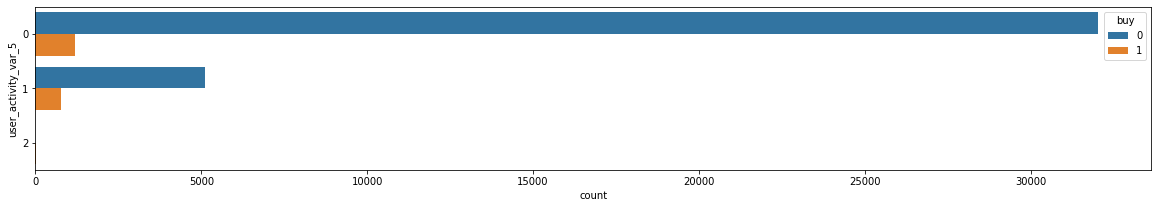

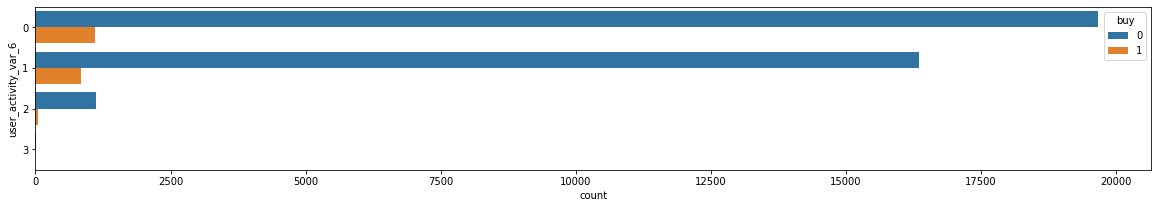

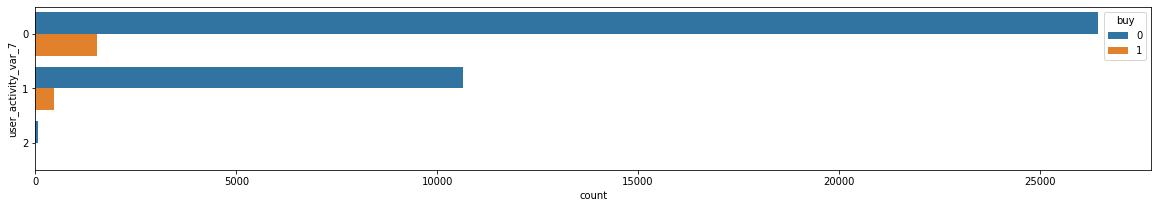

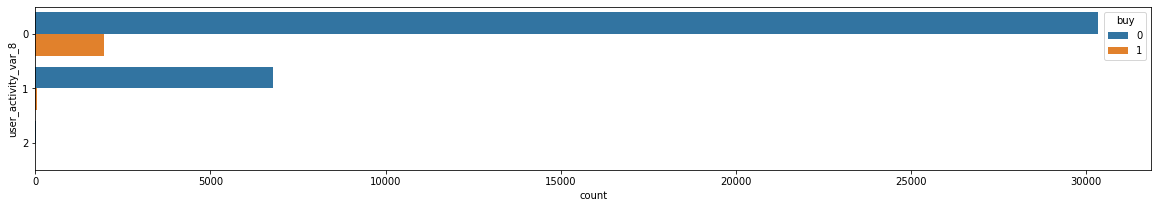

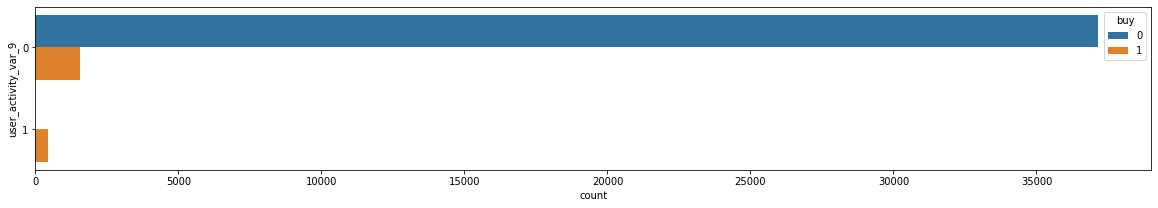

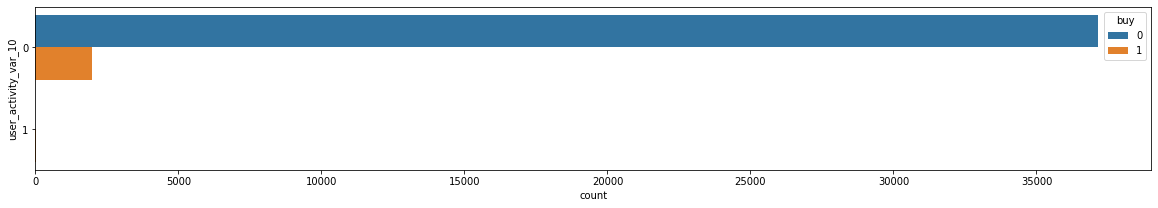

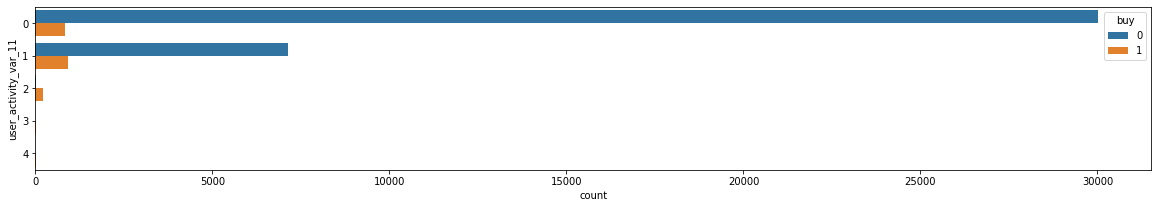

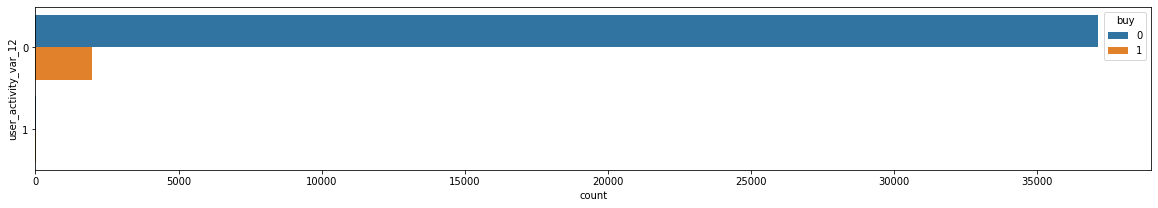

In [35]:
for var in user_vars:
    plt.figure(figsize=(20, 3))
    sns.countplot(y=var, data=train, hue='buy')
    plt.show()

user_activity_var_{2, 4, 8, 9, 11} show significant splits for predicting the target.  
user_activity_var_{10, 12} show extremely low variance.

In [36]:
train['user_activity_var_10'].value_counts()

0    39146
1       15
Name: user_activity_var_10, dtype: int64

In [37]:
train.loc[train['user_activity_var_10'] == 1].buy.value_counts()

1    15
Name: buy, dtype: int64

user_activity_var_10 has only 15 instances of value = 1, but in all those instances the customer ended up making a purchase, so it can be a significant part in predicting the target.

In [38]:
train['user_activity_var_12'].value_counts()

0    39139
1       22
Name: user_activity_var_12, dtype: int64

In [39]:
train.loc[train['user_activity_var_12'] == 1].buy.value_counts()

1    15
0     7
Name: buy, dtype: int64

user_activity_var_12 has only 22 instances of value = 1. The target variable is split among these instances unlike the previous case.

## Feature selection

In [40]:
features = [f for f in test.columns if f not in ('id', 'buy', 'created_at', 'signup_date')]

In [41]:
cat_features = ['campaign_var_1', 'campaign_var_2'] + user_vars
num_features = [f for f in features if f not in cat_features]

### Chi-square test of independence: categorical feature and categorical target

In [42]:
chi2_test = chi2(train[cat_features], train['buy'])
display(pd.DataFrame(data={'chi2': chi2_test[0], 
                           'p-value': chi2_test[1]}, 
                     index=cat_features))

,chi2,p-value
campaign_var_1,550.5365,9.6225e-122
campaign_var_2,265.8748,8.9949e-60
user_activity_var_1,50.9597,9.4282e-13
user_activity_var_2,4891.8263,0.0000e+00
user_activity_var_3,0.9405,3.3214e-01
user_activity_var_4,6031.0469,0.0000e+00
user_activity_var_5,910.0688,6.3533e-200
user_activity_var_6,2.9270,8.7110e-02
user_activity_var_7,22.9389,1.6724e-06
user_activity_var_8,306.7515,1.1140e-68


For a significance level of 0.05, user_activity_var_{3, 6} are independent of the target variable.

### Anova F-test: continuous feature and categorical target

In [43]:
anova_test = f_classif(train[num_features], train['buy'])
display(pd.DataFrame(data={'f-statistic': anova_test[0], 
                           'p-value': anova_test[1]}, 
                     index=num_features))

,f-statistic,p-value
products_purchased,1.3310,2.4863e-01
date_gap_months,1093.4472,1.5983e-236
created_at_quarter,13.8001,2.0361e-04
created_at_month,13.7576,2.0826e-04
created_at_day,1.2197,2.6943e-01
created_at_dayofweek,0.0948,7.5811e-01


From the date features we created, date_gap_months is very predictive of the target.  
Month and Quarter of the lead creation capture almost the same information hence the similar score. We will pick only the month among them.  
The other features are not predictive of the target.

### Mutual Information score

In [44]:
cat_mask = [f in cat_features for f in features] #boolean mask for discrete features
mi_scores = mutual_info_classif(train[features], train['buy'], 
                                discrete_features=cat_mask, 
                                random_state=SEED)

mi_scores_percent = mi_scores / sum(mi_scores) * 100

display(pd.DataFrame(data={'mi_score': mi_scores, 
                           'mi_score_percent': mi_scores_percent}, 
                     index=features))

,mi_score,mi_score_percent
campaign_var_1,5.0906e-03,2.8991
campaign_var_2,5.9971e-03,3.4153
products_purchased,3.5895e-05,0.0204
user_activity_var_1,1.1801e-03,0.6721
user_activity_var_2,2.0423e-02,11.6310
user_activity_var_3,1.3147e-05,0.0075
user_activity_var_4,2.5593e-02,14.5750
user_activity_var_5,1.0703e-02,6.0954
user_activity_var_6,8.5754e-05,0.0488
user_activity_var_7,4.7327e-04,0.2695


The features we rejected based on our previous tests also have poor MI scores.  
Some features have very high MI scores so we can create a reduced feature set using them.

## Feature sets

In [45]:
top_features = ['campaign_var_1', 'campaign_var_2', 'user_activity_var_2', 
                'user_activity_var_4', 'user_activity_var_5', 'user_activity_var_8',
                'user_activity_var_9', 'user_activity_var_11', 'date_gap_months',
                'created_at_quarter']

rejected_features = ['products_purchased', 'user_activity_var_3', 'user_activity_var_6',
                     'created_at_month', 'created_at_dayofweek']

selected_features = [f for f in features if f not in rejected_features]

# Modeling (baseline)

In [51]:
xtrain, xval, ytrain, yval = train_test_split(train, train['buy'],
                                              test_size=0.2,
                                              stratify=train['buy'],
                                              shuffle=True,
                                              random_state=SEED)

In [57]:
baseline = XGBClassifier(
    n_estimators=2000,
    tree_method='gpu_hist',
    enable_categorical=True,
    max_cat_to_onehot=5,
    objective='binary:logistic',
    eval_metric='error',
    scale_pos_weight=19, # negative samples / positive samples
    random_state=SEED)

### Expmt 1: All features

In [58]:
baseline.fit(
    xtrain[features], ytrain,
    verbose=0)

exp1_auc = roc_auc_score(yval, baseline.predict_proba(xval[features])[:, 1])
exp1_f1 = f1_score(yval, baseline.predict(xval[features]))
print(f'Expmt-1: f1_score = {exp1_f1:.5f}, AUC = {exp1_auc:.5f}')

Expmt-1: f1_score = 0.64141, AUC = 0.93071


### Expmt 2: Selected features

In [59]:
baseline.fit(
    xtrain[selected_features], ytrain,
    verbose=0)

exp2_auc = roc_auc_score(yval, baseline.predict_proba(xval[selected_features])[:, 1])
exp2_f1 = f1_score(yval, baseline.predict(xval[selected_features]))
print(f'Expmt-2: f1_score = {exp2_f1:.5f}, AUC = {exp2_auc:.5f}')

Expmt-2: f1_score = 0.61252, AUC = 0.91933


### Expmt 3: Top features

In [60]:
baseline.fit(
    xtrain[top_features], ytrain,
    verbose=0)

exp3_auc = roc_auc_score(yval, baseline.predict_proba(xval[top_features])[:, 1])
exp3_f1 = f1_score(yval, baseline.predict(xval[top_features]))
print(f'Expmt-3: f1_score = {exp3_f1:.5f}, AUC = {exp3_auc:.5f}')

Expmt-3: f1_score = 0.56835, AUC = 0.90575
